# Long Short-Term Memory (LSTM)

## Architecture

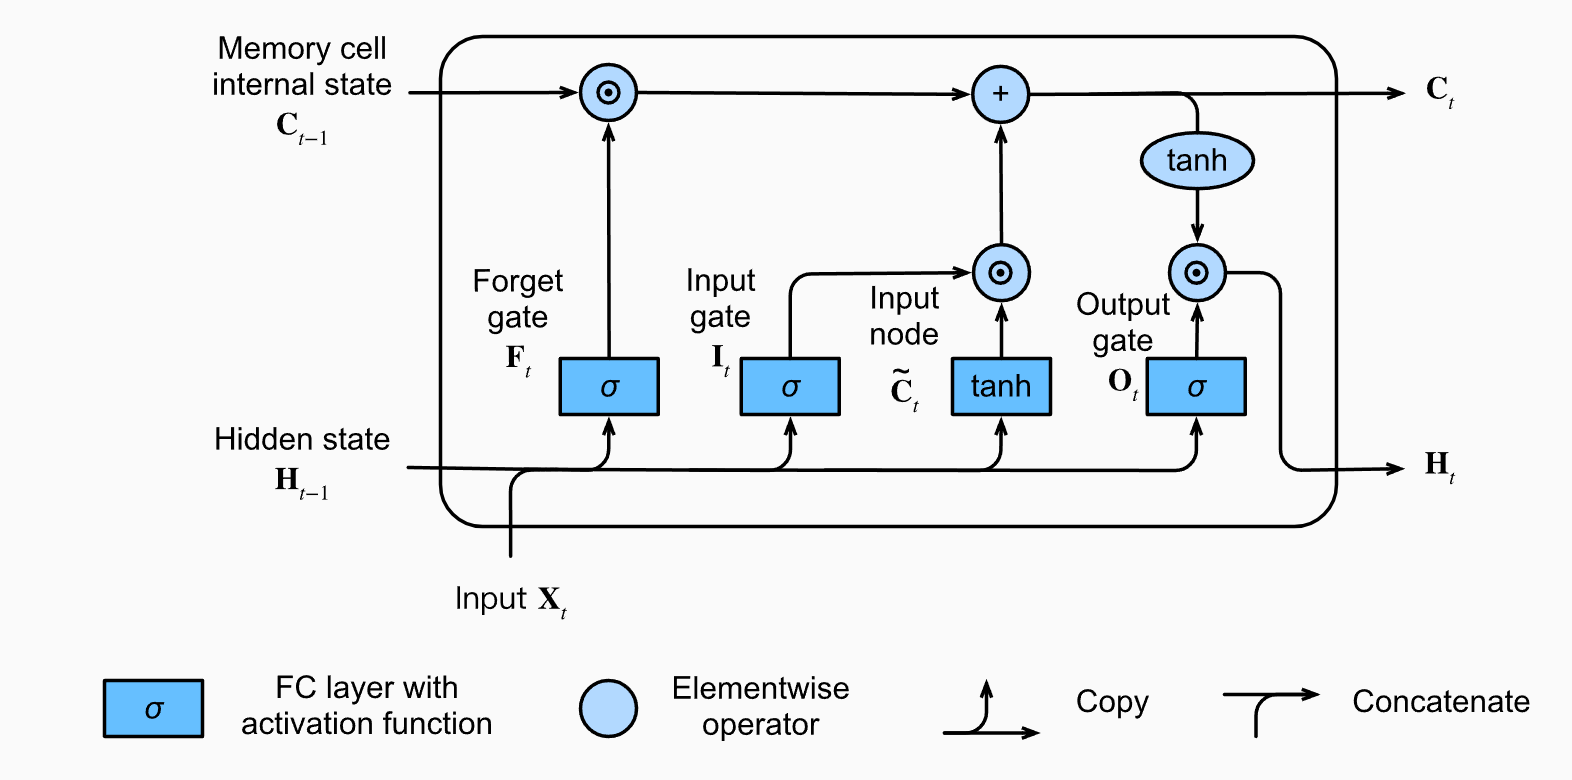

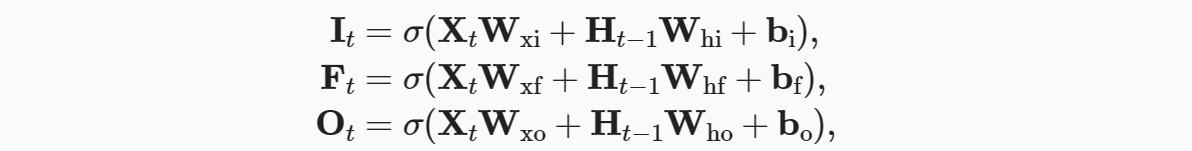

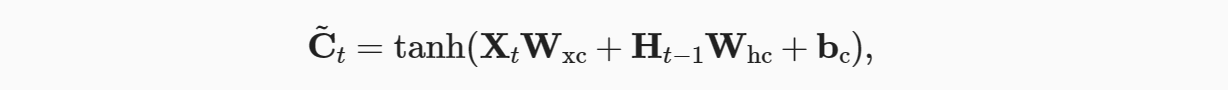

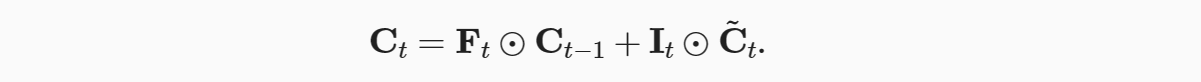

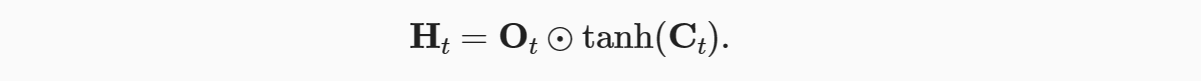

## Implementation from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### Initializing Model Parameters

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

### Training and Prediction

KeyboardInterrupt: 

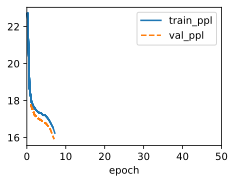

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
# ppl: perplexity. Lower -> better

## Concise Implementation

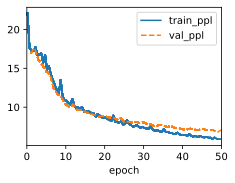

In [ ]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

# Gated Recurrent Units (GRU)

## Architecture

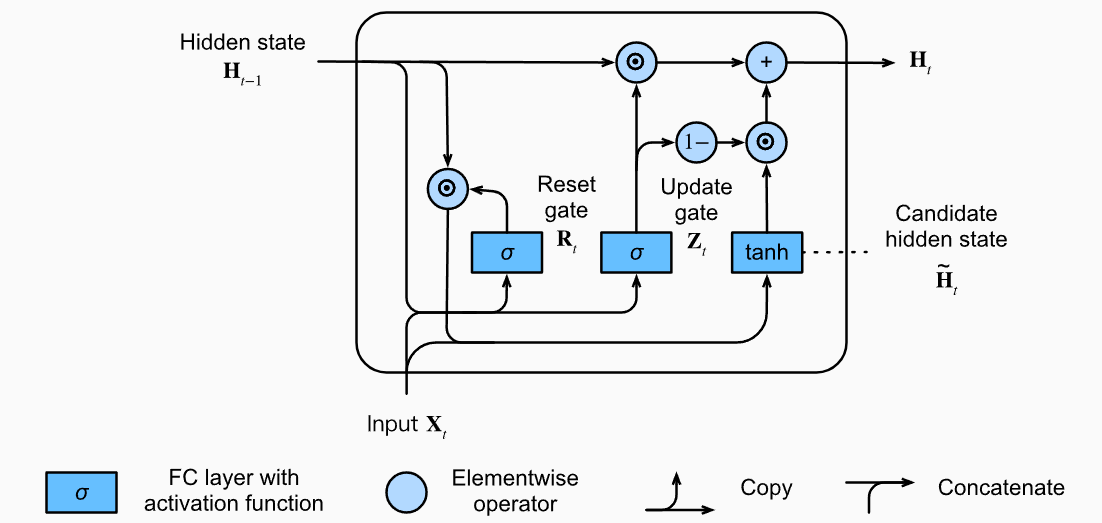

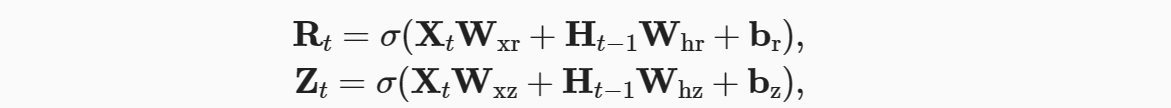

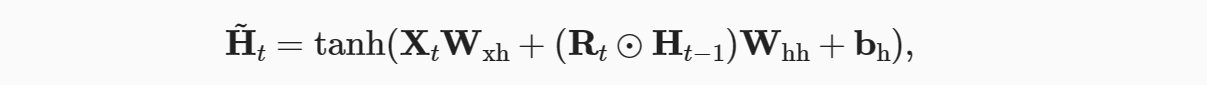

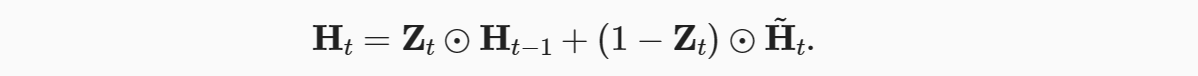

## Implementation from Scratch

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### Initializing Model Parameters

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

### Defining the Model

In [ ]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

Training

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Concise Implementation

In [ ]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

In [ ]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

# Self-Attention and Positional Encoding

## Architecture (Conparing with CNN and RNN)

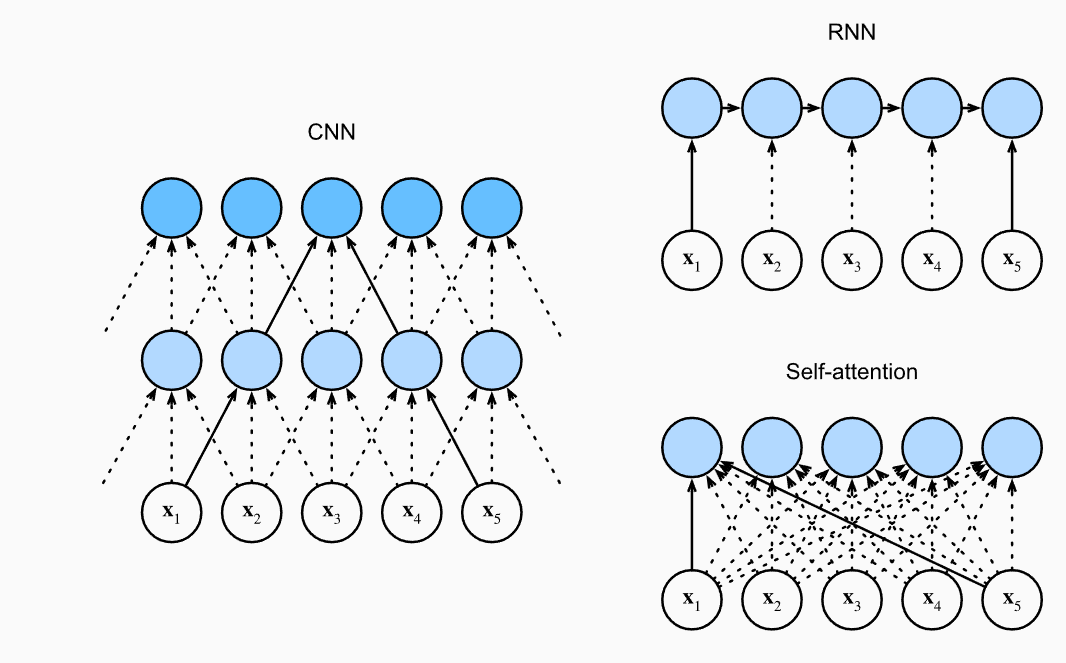

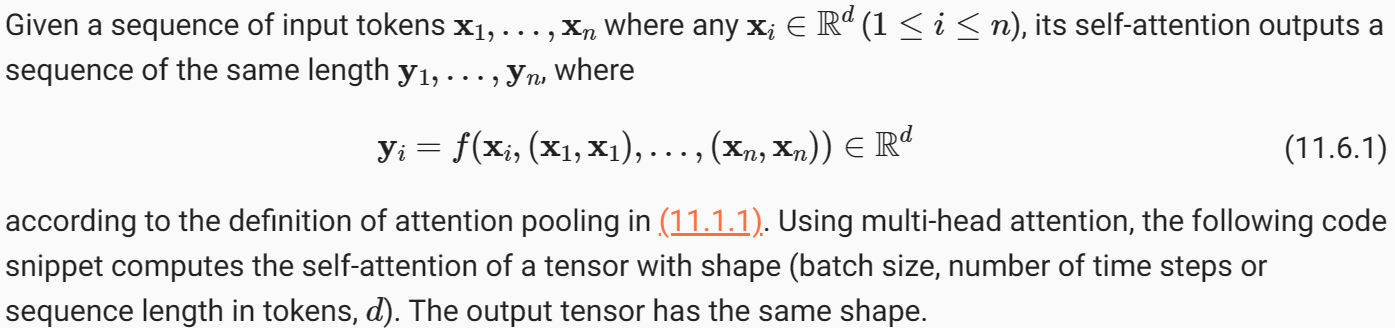

In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

## Positional Encoding

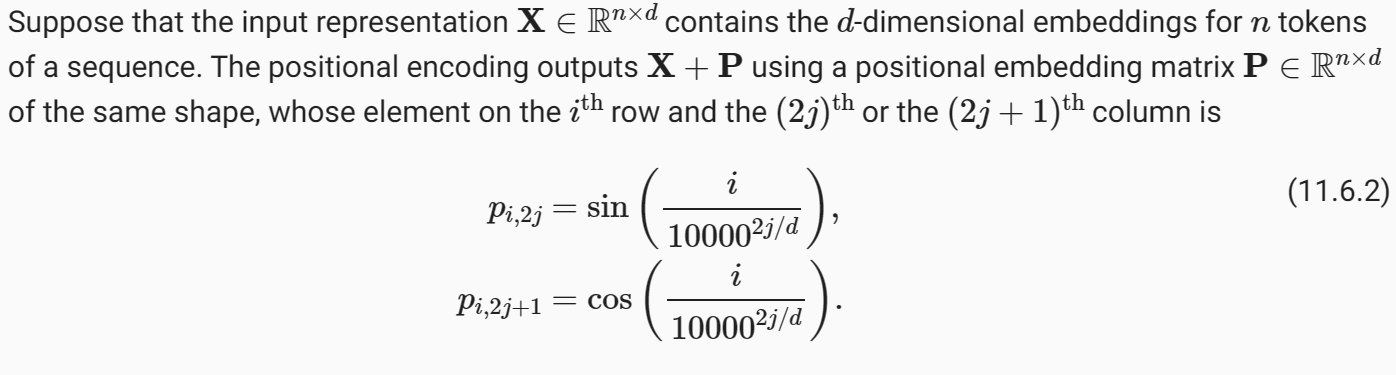

In [ ]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [ ]:
# rows correspond to positions within a sequence and columns represent different positional encoding dimensions
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])